# Trabajo practico integrado Comunicaciones digitales
Alumnos:
- Krede Julian
- Piñera, Nicolas

---

## Introduccion: 

Este trabajo práctico tiene como objetivo estudiar el funcionamiento del sistema de comunicación LoRaWAN el cual es una red de tipo LPWAN (Low Power Wide Area Network), la cual utiliza LoRa (Long Range) como su tecnología de modulación.

Una LPWAN es una red de telecomunicaciones diseñada específicamente para la comunicación de dispositivos que requieren cobertura de largo alcance y bajo consumo energético, características fundamentales en aplicaciones de Internet de las Cosas (IoT).

Con el fin de analizar en profundidad este sistema, se propone la lectura y el estudio de dos artículos científicos:
1. **"Frequency Shift Chirp Modulation: The LoRa Modulation"** – Lorenzo Vangelista
2. **"From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation"** – Zhenqiang Xu, Shuai Tong, Pengjin Xie y Jiliang Wang

A partir del análisis de estos trabajos, se derivan los siguientes resultados y conclusiones sobre el sistema de modulación y funcionamiento de la capa física (PHY) en LoRaWAN.

In [37]:
## Librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt


---

## 1. Codificador y Decodificador

### 1.1 Generador de Bits

Se define la funcion que genera el vector de variables aleatorias con distribucion uniforme

In [38]:
def generate_random_bits(total_bits):
    """
    Genera un vector de bits aleatorios (0 y 1) de longitud especificada.

    Args:
        cantidad_Bits(int) : Cantidad de bits a generar.

    Returns:
        bits_transmitidos(Array) : Vector de bits aleatorios (0 y 1).
    """
    return np.random.randint(0, 2, total_bits)


### 1.2 Codificador

La codificación propuesta se realiza mediante el polinomio de numeración posicional en base 2. Para ello, se requiere la elección de un parámetro conocido como **_Spreading Factor_ ($SF$)**, el cual puede tomar los siguientes valores: $\{7,8,9,10,11,12\}$. Este parámetro representa la cantidad de dígitos binarios que conforman un símbolo.

Para generar un símbolo, se utiliza la siguiente ecuación:

$$\Large s(nT_s) = \sum_{h=0}^{\text{SF}-1} \text{w}(nT_s)_h \cdot 2^h$$

Donde:
- $s(nT_s)$: Representa el simbolo resultante
- $w(nT_s)_h$: Es el digito binario en la posicion $h$
- $2^h$: Es el peso del digito binario, en funcion de la posicion del mismo
- $T_s$: Tiempo total que dura un simbolo
- $n$ es el índice del símbolo que indica la posición temporal dentro de la secuencia.

Por ejemplo, si se tiene un $SF=8$ y se desea codificar el dato $[0\ 1\ 1\ 1\ 1\ 0\ 0\ 0]$:

$$s(nT_s) = \sum_{h=0}^{7} \text{w}(nT_s)_h \cdot 2^h = 0 \times 2^7 + 1 \times 2^6 + 1 \times 2^5 + 1 \times 2^4 + 1 \times 2^3 + 0 \times 2^2 + 0 \times 2^1 + 0 \times 2^0 = 120$$

Se realiza la funcion que se va a encargar de codificar los bits generados en simbolos a transmitir, por medio de la ecuacion presentada en el documento. Este codificador recibe por parametro los bits generados y el SF (Spreading Factor)

In [39]:
def codificador(SF, bits_transmitidos):
    """
    Codifica un señal binaria mediante el polinomio de numeración posicional en base 2

    Args:
        SF (int): Spreading Factor
        bits_transmitidos (array): Vector de bits a transmitir

    Returns:
        simbolos (array): vector de simbolos codificados
    """
    cantidad_Bits = len(bits_transmitidos)  # Cantidad de bits transmitidos

    # Numero de simbolos a transmitir
    numero_de_simbolos = cantidad_Bits // SF

    # Vector de ceros con la longitud de la cantidad de simbolos
    simbolos = np.zeros(numero_de_simbolos, dtype=int)

    # Sumatoria - Ecuacion 1
    ## Simbolo i
    for i in range(numero_de_simbolos):

        # de 0 hasta SF-1
        for h in range(SF):
            "Toma bits dentro de un bloque de bits de largo SF"
            "Luego se suma cada bit con su peso para obtener el valor decimal del simbolo a transmitir"

            bit = bits_transmitidos[i * SF + h]  # Va desde el LSB al MSB
            simbolos[i] += bit * (2**h)  # Conversion a decimal

    return simbolos


### 1.3 Decodificador

El decodificador implementa el algoritmo de divisiones sucesivas por 2 (Base Binaria) para recuperar el dato a partir del símbolo recibido. El procedimiento consiste en dividir el número original entre 2 de forma repetida. En cada división, se registra el residuo o módulo (que siempre será 0 o 1), y se reemplaza el número por el cociente entero obtenido. Este proceso se repite hasta que el cociente sea igual a cero. Finalmente, el número binario se construye leyendo los residuos en orden inverso al que fueron generados; es decir, desde el último hasta el primero.

$$\large \mathbf{w}(nT_s)_h = \left( \left\lfloor \frac{s(nT_s)}{2^h} \right\rfloor \bmod 2 \right), \quad h = 0, 1, \dots, SF - 1$$

$$\mathbf{w}(nT_s) = \left[
\left\lfloor \frac{s(nT_s)}{2^0} \right\rfloor \bmod 2,\ 
\left\lfloor \frac{s(nT_s)}{2^1} \right\rfloor \bmod 2,\ 
\ldots,\ 
\left\lfloor \frac{s(nT_s)}{2^{SF - 1}} \right\rfloor \bmod 2
\right]$$

In [40]:
def decodificador(simbolos_rx, SF):
    """
    Decodifica una señal binaria mediante el polinomio de numeración posicional en base 2

    Args:
        SF (int, optional): Spreading factor
        simbolos_rx (array, optional): Vector de simbolos recibidos

    Returns:
        bits_rx (array): Vector bits decodificados.
    """
    if SF < 7 or SF > 12:
        raise ValueError("El Spreading Factor debe ser un valor entero entre 7 y 12")

    bits_rx = []

    for simbolo in simbolos_rx:  # Se toma cada simbolo
        bits = []
        for _ in range(SF):  # Se repite la division por 2 hasta SF-1
            bits.append(simbolo % 2)
            simbolo = simbolo // 2
        bits_rx.extend(bits)  # Agrega los bits en orden LSB a MSB

    return np.array(bits_rx, dtype=int)  # Asegura que sea un array plano de enteros


### 1.4 Bit error rate

El _Bit Error Rate_ (BER) representa la proporción de bits recibidos con error respecto al total de bits transmitidos. Se calcula de la siguiente forma:

$$BER=\frac{\text{número de bits erróneos}}{\text{total de bits transmitidos}}$$

In [41]:
def calculador_ber(bits_tx, bits_rx):
    """
    Calcula la tasa de error de bit (BER) entre los bits transmitidos y recibidos.

    Args:
        bits_tx (list): Arreglo unidimensional de bits transmitidos.
        bits_rx (list): Arreglo unidimensional de bits recibidos.

    Returns:
        BER (float): Tasa de error de bit (BER).
    """
    if len(bits_tx) != len(bits_rx):
        raise ValueError("Los arreglos de bits transmitidos y recibidos deben tener la misma longitud.")

    errores = np.sum(bits_tx != bits_rx)
    ber = errores / len(bits_tx)

    return ber


### 1.5 Grafica

Se define la funcion que grafica el histograma con los simbolos codificados para ver la cantidad de apariciones de los diferentes valores de simbolos

In [42]:
def graficar_histograma(simbolos_codificados):
    """
    Grafica el histograma de los símbolos codificados.

    Args:
        simbolos_codificados (list or array): Lista o array de símbolos codificados.
    """
    plt.figure(figsize=(14, 6))  # Aumenta el tamaño de la figura
    bins = range(min(simbolos_codificados), max(simbolos_codificados) + 2)
    plt.hist(simbolos_codificados, bins=bins, align='left', rwidth=0.85, color='skyblue', edgecolor='black')
    plt.xlabel('Símbolo', fontsize=16)
    plt.ylabel('Frecuencia', fontsize=16)
    plt.title('Histograma de símbolos codificados', fontsize=18)
    step = 8
    plt.xticks(bins[::step], fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### 1.6 Ejemplo

A continuacion se realiza un ejemplo de como funcionaria el codificacion, decodificaion y el calculo del **BER**

In [43]:
SF = 8  # Spreading Factor (debe ser un valor entre 7 y 12)
cant_simbolos = 10  # Cantidad de símbolos a transmitir
total_bits = SF * cant_simbolos  # Total de bits a transmitir

# Se aplica en Seccion 2
B = 125e3  # Ancho de banda (en Hz)
indice = 0


In [44]:
# Generación de bits aleatorios
bits_tx = generate_random_bits(total_bits)
print("---" * 10)
print("Primeros 20 bits a transmitir: ", bits_tx[0:20])
print("---" * 10)


------------------------------
Primeros 20 bits a transmitir:  [1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1]
------------------------------


In [45]:
simbolos = codificador(SF, bits_tx)
print("---" * 10)
print("Cantidad de simbolos detectados: ", len(simbolos))
print("Primeros 10 simbolos: ", simbolos[0 : 10])
print("---" * 10)


------------------------------
Cantidad de simbolos detectados:  10
Primeros 10 simbolos:  [ 65 205 233  18   2 176  67  88 190 242]
------------------------------


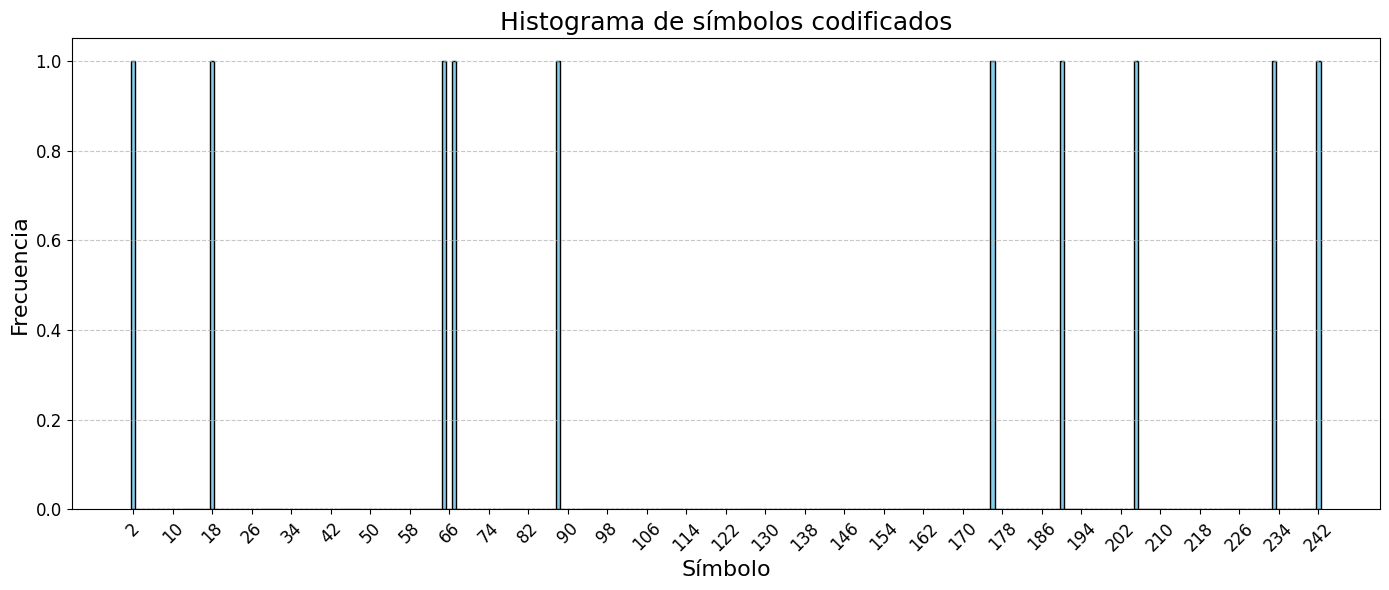

In [46]:
graficar_histograma(simbolos)


In [47]:
# Decodificaion de simbolos
bits_rx = decodificador(simbolos, SF)
print("---" * 10)
print("Primeros 20 bits recibidos: ", bits_rx[0:20])
print("---" * 10)


------------------------------
Primeros 20 bits recibidos:  [1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1]
------------------------------


In [48]:
print("---" * 10)
print("Bits originales (muestra):   ", bits_tx[: 2 * SF])
print("Bits decodificados (muestra):", bits_rx[: 2 * SF])
print("La tasa de error de bit (BER) es: ", calculador_ber(bits_tx, bits_rx) * 100, "%")
print("---" * 10)


------------------------------
Bits originales (muestra):    [1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1]
Bits decodificados (muestra): [1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1]
La tasa de error de bit (BER) es:  0.0 %
------------------------------


---

## 2. Conformador de onda y conformador de n-tuplas

### 2.1 Conformador de onda

El proximo paso en nuestro sistema de comunicacion es el conformador de onda o waveform former, el cual es la etapa posterior al codificador y ambos componen el bloque del transmisor. El conformador de onda implementa la modulación **_Frequency Shift Chirp Modulation_ (FSCM)**.

En esta modulación, cada símbolo se asocia a una frecuencia inicial $s(nT_s)$. A partir de esta frecuencia, la señal modulada presenta un barrido lineal en frecuencia (tipo chirp), donde la frecuencia incrementa linealmente con el tiempo, siguiendo el índice $k=0,1,...,2^{SF}-1$, hasta alcanzar un valor máximo de $2^{SF}$. 

Luego, la frecuencia decae hasta 0 y vuelve a incrementarse hasta volver al valor de $s(nT_s)$, completando así el periodo del simbolo $T_s$. Esta modulación al realizarse con una señal compleja, se compone de una componente real o fase (I) y otra componente imaginaria o cuadratura (Q). Esto se representa por la siguiente ecuacion: 


$$\Large c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi[(s(nT_s)+k){\bmod{2^{SF}}}](kT\frac{B}{2^{SF}})}\quad k=0,...,2^{SF}-1$$

En la misma: 
- Toma un símbolo codificado $𝑠∈{0,1,...,2^{𝑆𝐹}−1}$
- Lo inserta como un shift de frecuencia inicial en una señal chirp.
- Genera una onda compleja cuya frecuencia aumenta linealmente en el tiempo (chirp) y comienza en una frecuencia determinada por **𝑠**.

$c(nT_s + kT)$ es una funcion que tiene dos argumentos constantes $T_s$ que representa el tiempo que dura un simbolo y $T$ que representa el periodo de muestreo dentro de cada simbolo. El primer argumento $kT$ nos dice donde va a existir la señal (donde se muestrea).

Se conforma una señal compleja (exponencial) la cual podriamos verla como una $e^{j2\pi f t} = cos(2\pi f t) + j.sen(2\pi f t)$ (relacion de euler). Donde:

- $f(kT)=(s(nT_s)+k) \bmod 2^{SF}\cdot \frac{B}{2^{SF}}$
- $t=kT$

Dado que se tiene una señal de frecuencia variable, la fase de la señal modulada se obtiene integrando la frecuencia instantánea a lo largo del tiempo. Esto permite expresar la señal modulada como una exponencial compleja cuya fase varía cuadráticamente con el tiempo, característica fundamental de los chirps utilizados en LoRa.
Para obtener la fase $\phi(t)$ de la exponencial compleja en $c(nT_s + kT)$:

$$\phi(t)=2\pi\int^t_0{f(\tau)d\tau} $$

En el dominio discreto $k=\frac{\tau}{T}$ Entonces:

$$\phi(t) =2\pi \int^t_0 \left[(s+\frac{\tau}{T}) \frac{B}{2^{SF}}\right]d\tau =2\pi \frac{B}{2^{SF}} \int^t_0 \left[(s+\frac{\tau}{T})\right]d\tau =2\pi \frac{B}{2^{SF}}\left[s t +\frac{t^2}{2T}\right]$$

Entonces. Remplazando $t$ por $kT$:

$$\phi(kT) = 2\pi \frac{B}{2^{SF}}\left[s (kT)+\frac{(kT)^2}{2T}\right]$$

Se llega a:

$$\phi(kT) = 2\pi \frac{B\cdot T}{2^{SF}}\left[s\cdot k+\frac{k^2}{2}\right]= 2\pi \frac{B\cdot T}{2^{SF}}(s+\frac{k}{2})k$$
$$\phi(kT)= 2\pi (s+\frac{k}{2})\frac{B}{2^{SF}}\cdot t$$

Esto muestra por qué en la implementación del código se calcula el argumento de la exponencial como:
$$\text{arg}= f\cdot t \cdot 0.5 \quad f\neq s$$

Analizando las ecuación se pueden observar:
- $k$ Es el indice de tiempo discreto que varia la frecuencia linealmente.
- La frecuencia inicial (cuando $k=0$) viene dado por el valor del simbolo $s(nT_s)$
- El modulo de $(s(nT_s) + k)$ en base $2^{SF}$ tiene por fin limitar el crecimiento lineal de la frecuencia hasta un valor de frecuencia maximo $2^{SF}-1$ con el proposito de limitar el ancho de banda. Esta operacion genera un discontinuidad en la frecuencia haciendo que la misma caiga desde el valor maximo hasta $0$ para luego continuar creciendo hasta el valor inicial $s(nT_s)$ finalizando el periodo $T_s$ del simbolo.

A continuacion se presenta el **conformador de onda**, el cual define:
- El numero de muestras por simbolo $(N_s = 2^{SF})$
- Periodo de muestreo $(T = 1/B)$
- Como varia $k$ al momento de muestrear representado con $delta = \frac{1}{muestrasPorChirp}$
- El total de muestras $= N_s * muestrasPorChirp$
- La $F_{max}$ con la cual limitamos el modulo de la funcion chirps

Por cada simbolo codificado, genera su funcion chirps compleja, devuelve una matriz en la cual cada fila tiene los valores de la funcion chirp correspondiente a su simbolo, y en las columnas tiene los valores de esa funcion chirp en cada tiempo de muestreo

In [49]:
def conformador_de_onda(simbolos, SF, B=125e3):
    """
    Genera la forma de onda LoRa para una secuencia de símbolos usando la ecuación 2 o 3 del paper.

    Parámetros:
    - simbolos: matriz unidimensional de enteros entre 0 y 2**SF - 1
    - SF: Spreading Factor
    - B: Ancho de banda (Hz), por defecto 125 kHz

    Retorna:
    - matriz de forma (len(simbolos), 2**SF) con los chirps generados
    """
    Ns = 2**SF  # Muestras por símbolo
    k = np.arange(Ns)
    Ts = Ns / B  # Duración de símbolo

    simbolos_modulados = []

    for s in simbolos:
        # Ecuación 2/3 del paper: chirp modulado en frecuencia
        # s: símbolo, k: índice de muestra
        # x_s[k] = exp(j*2*pi*( (k^2)/(2*Ns) + (s*k)/Ns ))
        chirp = (1 / np.sqrt(Ns)) * np.exp(1j * 2 * np.pi * ( (k**2)/(2*Ns) + (s * k)/Ns ))
        simbolos_modulados.append(chirp)

    return np.array(simbolos_modulados)  # Matriz de salida (símbolos x muestras)


### 2.2 Formador de ntuplas

Para recuperar el simbolo modulado se proyecta la señal recibida $r(nT_s + kT)$ en el conjunto de bases conjugadas con las que se moduló la señal, en nuestro caso la base con la que se modulo la señal esta formada por una unica señal $c(nT_s + kT)$. Por lo tanto la proyección:

$$\langle r(nT_s+kT),c(nT_s+kT)|_{s(nT_s)=q} \rangle$$

$$=\sum_{k=0}^{2^{SF}-1}r(nT_s+kT)\, \cdot \, c^*(nT_s+kT)|_{s(nT_s)=q}$$

Se llega a la siguiente expresión:

$$=\sum_{k=0}^{2^{SF}-1}\underbrace{r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}}_{d(nT_s + kT)}\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

Reescribiendo el producto:
$$d(nT_s + kT)=r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}$$

Se tiene:

$$\sum_{k=0}^{2^{SF}-1}d(nT_s + kT)\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

La cual es la transformada de Fourier discreta de la señal $d(nT_s + kT)$

In [50]:
def formador_de_ntuplas(simbolos_modulados, SF):
    """
    Recupera los símbolos modulados mediante FSCM y estima los símbolos transmitidos a partir de ellos.

    Args:
        simbolos_modulados (Array): Lista de símbolos modulados en forma de chirps.
        SF (int): Spreading Factor.

    Return:
        simbolos_estimados (list): Lista de símbolos estimados.
    """
    Ns = 2**SF
    k = np.arange(Ns)
    # Upchirp base para dechirp
    upchirp = (1 / np.sqrt(Ns)) * np.exp(1j * 2 * np.pi * ( (k**2)/(2*Ns) ))
    dechirp = np.conj(upchirp)

    simbolos_estimados = []

    for r in simbolos_modulados:
        # Dechirp multiplicando por el conjugado del upchirp base
        r_dechirped = r * dechirp
        fft_out = np.fft.fft(r_dechirped)
        simbolo_estimado = int(np.argmax(np.abs(fft_out)))
        simbolos_estimados.append(simbolo_estimado % Ns)

    return simbolos_estimados


### 2.3 Symbol error rate (SER)

El _Symbol Error Rate_ (SER), similar al BER, representa la proporción de simbolos recibidos con error respecto al total de simbolos transmitidos. Se calcula de la siguiente forma:

$$SER=\frac{\text{número de simbolos erróneos}}{\text{total de simbolos transmitidos}}$$

Los simbolos que salen del **n-tuple former** y se comparan con los simbolos que entran al **waveform former**

In [51]:
def calculador_ser(simbolos_tx, simbolos_rx):
    """
    Calcula la tasa de error de símbolos (SER) entre los símbolos transmitidos y recibidos.

    Args:
        simbolos_tx (list): Arreglo unidimensional de símbolos transmitidos.
        simbolos_rx (list): Arreglo unidimensional de símbolos recibidos.

    Returns:
        SER (float): Tasa de error de símbolos (SER).
    """
    if len(simbolos_tx) != len(simbolos_rx):
        raise ValueError("Los arreglos de símbolos transmitidos y recibidos deben tener la misma longitud.")

    errores = np.sum(simbolos_tx != simbolos_rx)
    ser = errores / len(simbolos_tx)

    return ser


### 2.4 Grafica de Funciones

A continuacion se definen funciones para graficar las señales moduladas. La primer funcion grafica la funcion modulada de un solo simbolo tanto la parte real como la imaginaria. 

In [52]:
def graficar_señal_modulada(simbolos_modulados, indice, SF, B):
    """
    Grafica la señal modulada en tiempo (I y Q) de un símbolo dado por su índice dentro de la matriz de símbolos modulados.

    Args:
        simbolos_modulados (Array): Lista de símbolos modulados en forma de chirps.
        indice (int): Posición del símbolo que se desea graficar.
        SF (int): Spreading Factor.
        samples_per_chirp (int): Muestras por símbolo o factor de oversampling.
        B (int): Ancho de banda (Hz).
    """
    Ns = 2**SF  # Muestras base por símbolo (sin oversampling)
    total_muestras = Ns # Muestras por símbolo
    T = 1 / B  # Duración total del símbolo (s)
    T_muestra = T # Duración de cada muestra (s)

    tiempo = np.arange(total_muestras) * T_muestra * 1e6  # Tiempo en microsegundos

    muestra_simbolo_mod = simbolos_modulados[indice]
    I = np.real(muestra_simbolo_mod)  # Componente en fase
    Q = np.imag(muestra_simbolo_mod)  # Componente en cuadratura

    # Grafica
    fig, axs = plt.subplots(2, 1, figsize=(15, 4), sharex=True)
    axs[0].plot(tiempo, I, color="blue", linewidth=0.9)
    axs[0].set_title(f"Chirp LoRa - Fase (I) - índice {indice} (SF={SF})")
    axs[0].set_ylabel("Amplitud")
    axs[0].grid()

    axs[1].plot(tiempo, Q, color="red", linewidth=0.9)
    axs[1].set_title(f"Chirp LoRa - Cuadratura (Q) - índice {indice} (SF={SF})")
    axs[1].set_xlabel("Tiempo [μs]")
    axs[1].set_ylabel("Amplitud")
    axs[1].grid()

    plt.tight_layout()
    plt.show()


La segunda funcion realiza la grafica de la fase pero para un grupo de simbolos

In [53]:
def graficar_todas_las_senales_moduladas(simbolos_modulados, SF, B, max_muestras=None):
    """
    Grafica la señal modulada completa solo de la parte en fase (I) concatenando los símbolos,
    y colorea cada símbolo con un color distinto.

    Args:
        simbolos_modulados (Array): Lista de símbolos modulados en forma de chirps.
        SF: Spreading Factor.
        samples_per_chirp: Muestras por símbolo o factor de oversampling.
        B: Ancho de banda (Hz).
        max_muestras: Cantidad de símbolos a graficar (opcional).
    """
    Ns = 2**SF
    total_muestras = Ns
    T = 1 / B
    T_muestra = T 

    if max_muestras is None:
        max_muestras = len(simbolos_modulados)

    cmap = plt.get_cmap("tab10")

    plt.figure(figsize=(15, 3))

    for i in range(max_muestras):
        simbolo = simbolos_modulados[i]
        I = np.real(simbolo)
        tiempo_local = (np.arange(i * total_muestras, (i + 1) * total_muestras) * T_muestra * 1e6)
        plt.plot(tiempo_local, I, label=f"Símbolo {i}", color=cmap(i % 10), linewidth=0.6)

    plt.title(f"Fase (I) de todos los símbolos concatenados (SF={SF})")
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Por ultimo se presenta la funcion que grafica el barrido lineal de frecuencia para un simbolo y para todos los simbolos enviados

In [54]:
def plot_lora_frequency_chirp(simbolos,indice, sf=8, B=125e3):
    """
    Genera y grafica la frecuencia instantánea (chirp) del símbolo LoRa dado.

    Args:
        simbolo (int): lista de simbolos 
        indice (int): indice del simbolo a graficar
        sf (int): Spreading Factor (por defecto 7)
        Bw_kHz (float): Ancho de banda en kHz (por defecto 125)
    """
    # Parámetros
    s = simbolos[indice]
    Ns = 2**sf  # Numero de muestra
    Ts = Ns / B  # Duración del símbolo en segundos
    samples = Ns  # 1 muestra por paso
    t = np.linspace(0, Ts, samples)  # vector de tiempo

    # Cálculo de frecuencia instantánea
    f_inst = (s * B / Ns + (B / Ts) * t) % B
    f_inst_kHz = f_inst / 1e3
    t_ms = t * 1e3  # tiempo en milisegundos

    # Gráfico
    plt.figure(figsize=(12, 4))
    plt.title("LoRa Modulation - Chirp Frecuencia Instantánea", fontsize=16, weight="bold")
    plt.xlabel("Time [ms]", fontsize=14)
    plt.ylabel("Frequency [kHz]", fontsize=14)
    plt.plot(t_ms, f_inst_kHz, lw=2, color="deepskyblue")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [55]:
def plot_lora_frequency_chirps(simbolos, SF=8, B=125e3):
    """
    Genera y grafica la frecuencia instantánea (chirp) de una secuencia de símbolos LoRa.

    Args:
        simbolos (list or array): Secuencia de valores de símbolos LoRa (enteros entre 0 y 2^SF - 1)
        SF (int): Spreading Factor
        B (float): Ancho de banda en Hz
    """
    Ns = 2**SF # Número de muestras por símbolo
    Ts = Ns / B # Duración del símbolo en segundos
    samples = Ns # 1 muestra por paso
    t_total = []
    f_total = []

    for i, s in enumerate(simbolos):
        t = np.linspace(i * Ts, (i + 1) * Ts, samples, endpoint=False)
        f_inst = (s * B / Ns + (B / Ts) * (t - i * Ts)) % B
        t_total.append(t)
        f_total.append(f_inst)

    # Concatenar todo el tiempo y frecuencia
    t_total = np.concatenate(t_total) * 1e3 # a milisegundos
    f_total = np.concatenate(f_total) / 1e3 # a kHz

    # Graficar
    plt.figure(figsize=(12, 4))
    plt.title("LoRa Modulation - Frecuencia Instantánea", fontsize=16, weight="bold")
    plt.xlabel("Tiempo [ms]", fontsize=14)
    plt.ylabel("Frecuencia [kHz]", fontsize=14)
    plt.plot(t_total, f_total, lw=2, color="deepskyblue")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


### 2.5 Ejemplo

Se continua el proceso iniciado en el capitulo anterior agregando el **conformador de ondas** luedo de la codificacion de los bits, y agregando el **conformador de n-tuplas** antes del decodificador y realizando el calculo del **SER**. Se define un nuevo parametro que es el **samples_per_chirp** el cual nos define cuantas veces mas se va a muestrear la señal chirp resultante

In [56]:
simbolos_modulados = conformador_de_onda(simbolos, SF, B)
print("---" * 10)
print("Salida del conformador de onda:", simbolos_modulados[0])
print("---" * 10)


------------------------------
Salida del conformador de onda: [ 6.25000000e-02+0.00000000e+00j -2.30045143e-03+6.24576490e-02j
 -6.21990454e-02-6.12607127e-03j  1.14399930e-02-6.14440930e-02j
  5.98087710e-02+1.81427923e-02j -2.60268475e-02+5.68229989e-02j
 -5.19668508e-02-3.47231396e-02j  4.36485156e-02-4.47331766e-02j
  3.47231396e-02+5.19668508e-02j -5.85836882e-02+2.17761675e-02j
 -6.12607127e-03-6.21990454e-02j  6.14440930e-02+1.14399930e-02j
 -2.94622961e-02+5.51200790e-02j -4.25375624e-02-4.57908920e-02j
  5.77424708e-02-2.39177145e-02j  7.66971143e-04+6.24952939e-02j
 -5.77424708e-02-2.39177145e-02j  4.57908920e-02-4.25375624e-02j
  1.81427923e-02+5.98087710e-02j -6.14440930e-02-1.14399930e-02j
  3.96495803e-02-4.83131533e-02j  2.17761675e-02+5.85836882e-02j
 -6.12990800e-02-1.21931451e-02j  4.36485156e-02-4.47331766e-02j
  1.21931451e-02+6.12990800e-02j -5.68229989e-02-2.60268475e-02j
  5.51200790e-02-2.94622961e-02j -1.14399930e-02+6.14440930e-02j
 -3.96495803e-02-4.83131533

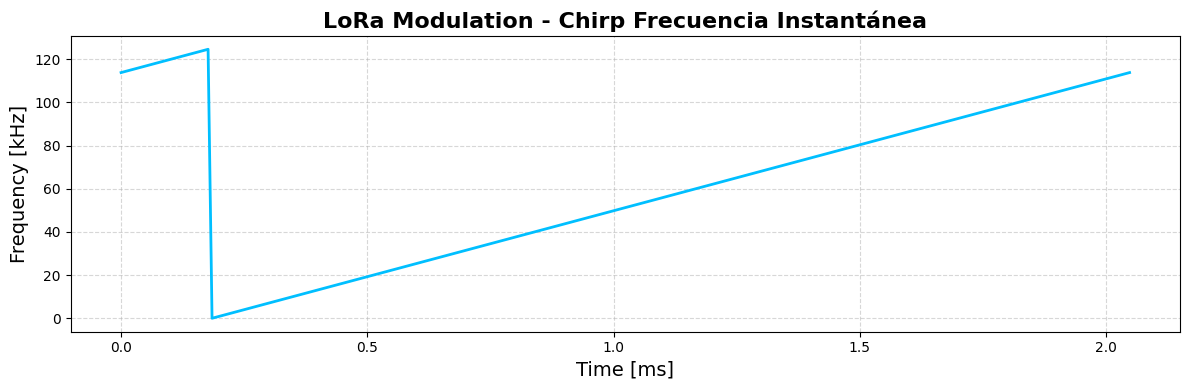

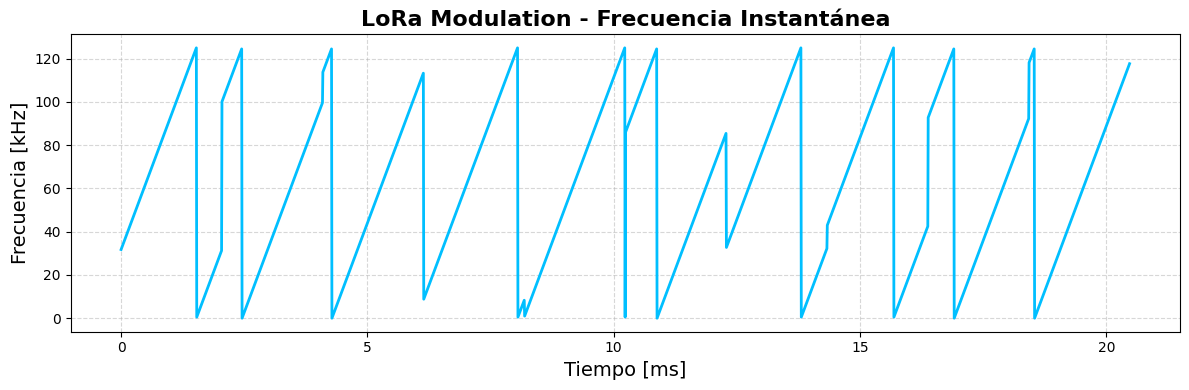

In [57]:
plot_lora_frequency_chirp(simbolos,2, SF)
plot_lora_frequency_chirps(simbolos, SF, B=125e3)


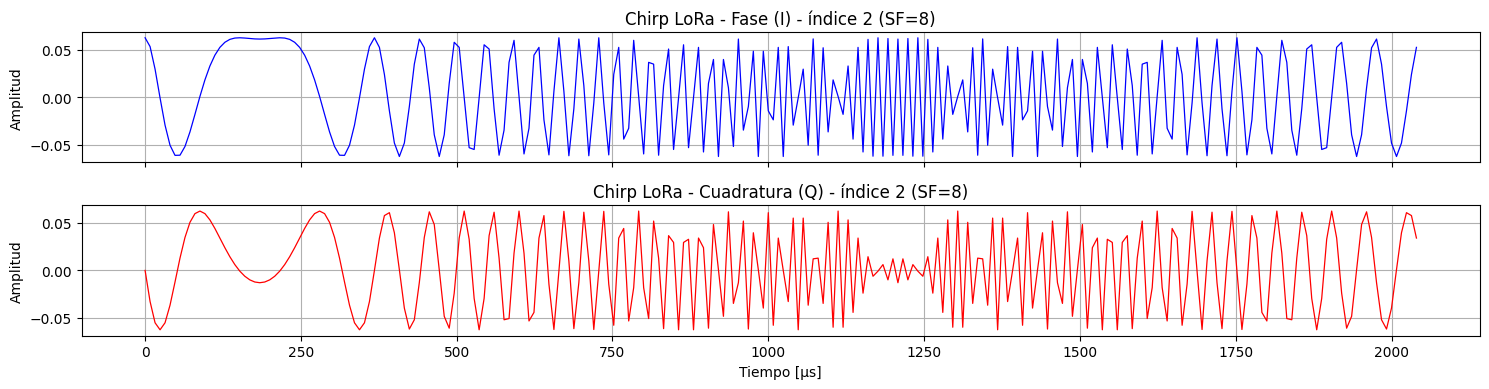

In [58]:
graficar_señal_modulada(simbolos_modulados, 2, SF,B)


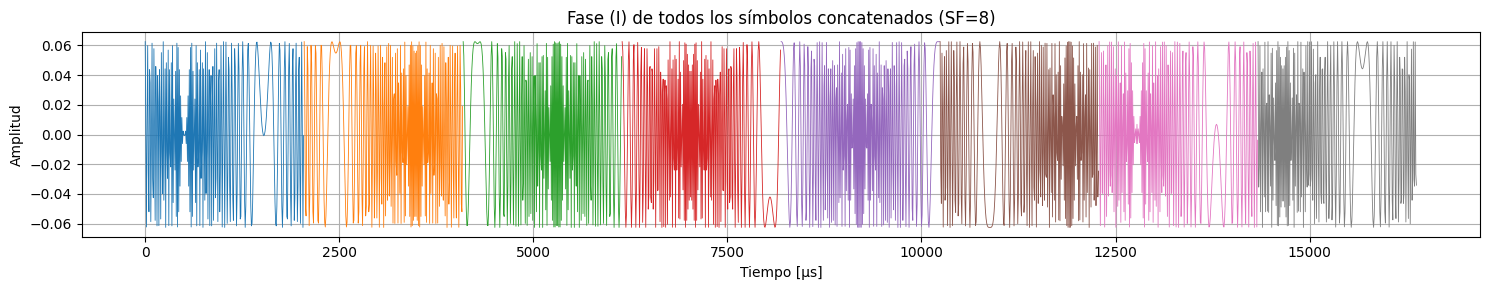

In [59]:
graficar_todas_las_senales_moduladas(simbolos_modulados, SF, B, 8)


In [60]:
simbolos_rx = formador_de_ntuplas(simbolos_modulados, SF)
print("---" * 10)
print("Salida del conformador de onda: ", simbolos_rx)
print("---" * 10)


------------------------------
Salida del conformador de onda:  [65, 205, 233, 18, 2, 176, 67, 88, 190, 242]
------------------------------


In [61]:
print("---" * 10)
print("Símbolos codificados:", simbolos)
print("Símbolos recibidos:", simbolos_rx)
print("La tasa de error de simbolos (SER) es: ",calculador_ser(simbolos, simbolos_rx) * 100,"%",)
print("---" * 10)


------------------------------
Símbolos codificados: [ 65 205 233  18   2 176  67  88 190 242]
Símbolos recibidos: [65, 205, 233, 18, 2, 176, 67, 88, 190, 242]
La tasa de error de simbolos (SER) es:  0.0 %
------------------------------


---

## 3. Canal

En este apartado se utilizaran dos tipos de canales simulados
- Canal **AWGN**
- Canal **Selectivo en Frecuencia**

Con el fin de verificar y validar el funcionamiento del software realizado para posteriormente llevarlo a una implementancion en un canal real

### 3.1 Canal AWGN

El primer canal a simular es el **canal AWGN** el cual suma un ruido blanco gaussiano a la señal transmitida, ruido que tiene una distribucion normal con media cero y varianza $\sigma^2$. El modelo matematico propuesto por Vangelista es el siguiente:

$$r(nT_s+kT)=c(nT_s +kT)+w(nT_s +kT)$$

Donde:

- $𝑐(𝑛𝑇_𝑠+𝑘𝑇)$ : es la señal chirp transmitida para el símbolo $𝑠$
- $𝑤(𝑛𝑇_𝑠+𝑘𝑇)$ : es ruido blanco gaussiano complejo
- $r(nT_s+kT)$ : es la señal recibida

La señal transmitida es una secuencia de muestras complejas (un chirp), y a cada muestra le suma un valor complejo aleatorio. Ahora simularemos el canal AWGN sin el componente de filtrado del canal, es decir, unicamente agregando ruido al a señal.

#### 3.1.1 Obtencion de la potencia del ruido a partir de la SNR

La potencia de una señal aleatoria $x$ se define como:

$$P_x = \mathbb{E}[|x|^2]$$

Donde $|x|^2 = x.x^*$, producto de $x$ por su conjugado. 

Desarrollando la expresion:

$$P_x=\mathbb{E}[(x - \mu +\mu)^2] =\mathbb{E}[(x - \mu)^2] + |\mu|^2 + 2\cdot \mathbb{E}[x - \mu]$$

Donde:

$2\cdot \mathbb{E}[x - \mu]=2 (\mathbb{E}[x]−\mathbb{E}[\mu])=2\cdot (\mu-\mu)=0$

$\mathbb{E}[(x - \mu)^2]=Var(x)$

Entonces:

$$P_x = \mathbb{E}[|x|^2]=\text{Var}(x) + |\mu|^2$$

Ecuacion que utilizaremos para calcular la potencia de la señal transmitida

Si la media es cero ($\mu=0$):

$$P_x = \text{Var}(x) = \sigma^2$$

Ecuacion utilizada para calcular la potencia de ruido al ser un canal AWGN

En AWGN, las partes real e imaginaria son independientes e idénticamente distribuidas cada una con varianza $\frac{\sigma^2}{2}$, si $x = a + jb$ entonces $P_x = Var(a) + Var(b)= \frac{\sigma^2}{2} + \frac{\sigma^2}{2}  = \sigma^2$

Para modelar el canal se utiliza un ruido complejo con distribucion normal, cuya desviacion estandar para la parte real e imaginaria que cumpla la descripcion matematica anterior es:

$$\sigma = \sqrt{\frac{Potencia_{Ruido}}{2}}$$

In [62]:
def canal_AWGN(signal, pot_ruido):
    """
    Simula un canal AWGN. Con media cero y varianza pot_ruido/2.

    Args
        signal (array)
        pot_ruido (int)
    
    Return
        Señal + Ruido (array)
    """
    # el parametro que requiere la funcion random.normal es el desvio estandar, el cual es la raiz cuadrada de la potencia
    # la potencia es divida en 2 porque el ruido es complejo (I y Q)
    desv_est = np.sqrt(pot_ruido / 2)
    ruido = np.random.normal(0, desv_est, size=signal.shape) + 1j * np.random.normal(0, desv_est, size=signal.shape)
    return signal + ruido


La Relacion Señal Ruido se define como $SNR = \frac{P_s}{P_n}$ siendo $P_s$ la potencia de la señal y $P_n$ la potencia del ruido. Para calcular la SNR en decibelios se utiliza la siguiente formula

$$\large \text{SNR}_{dB}=10\cdot log(\frac{P_s}{P_n})$$

Despejando, la potencia de Ruido se puede calcular realizando

$$\large P_n=\frac{P_s}{10^{\frac{\text{SNR}_{dB}}{10}}}$$

In [63]:
def potencias_de_ruido(pot_signal, lim_inf=-12, lim_sup=0):
    """
    Calcula el rango de potencias de ruido en escala lineal para un rango de SNR en dB.

    Args:
        pot_signal (float): Potencia de la señal en escala lineal.
        lim_inf (int, optional): Valor de SNR inferior. Defaults to -12.
        lim_sup (int, optional): Valor de SNR superior. Defaults to -1.

    Returns:
        list: lista de SNR en dB
        list: lista de potencias de ruido.
    """
    snr_db = np.arange(lim_inf, lim_sup + 1, 1)
    pot_ruido = pot_signal / (10 ** (snr_db / 10))
    return snr_db, pot_ruido


Se plantea una funcion la cual grafica la modulacion chirp para un simbolo y se superpone con la misma chirp pero con el ruido del canal AWGN

In [64]:
def graficar_chirp_con_y_sin_ruido(simbolos_modulados, indice, SF, B, pot_ruido):
    """
    Grafica la parte real o imaginaria del chirp LoRa con y sin ruido.

    Args:
        simbolos_modulados (Array): Lista de símbolos modulados en forma de chirps.
        indice (int): Índice del símbolo a graficar.
        SF (int): Spreading Factor.
        B (float): Ancho de banda en Hz.
        pot_ruido (float): Potencia de ruido (en escala lineal).
    """
    simbolo = simbolos_modulados[indice]
    simbolo_con_ruido = canal_AWGN(simbolo, pot_ruido)

    num_muestras = len(simbolo)
    Ts = (2**SF) / B # Duración total de un chirp
    T_muestra = Ts / num_muestras # Duración de una muestra
    tiempo = np.arange(num_muestras) * T_muestra * 1e6  # Tiempo en μs

    sin_ruido = np.real(simbolo)
    con_ruido = np.real(simbolo_con_ruido)
    titulo_parte = "Parte Real"

    plt.figure(figsize=(12, 4))
    plt.plot(tiempo, sin_ruido, label='Sin Ruido', linewidth=1.2, color='blue')
    plt.plot(tiempo, con_ruido, label='Con Ruido', linewidth=1.2, color='orange', alpha=0.7)
    plt.title(f"Chirp LoRa - {titulo_parte} - Índice {indice} (SF={SF})", fontsize=14, weight='bold')
    plt.xlabel("Tiempo [μs]")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


#### 3.1.2 Canal Flat

La modulacion FSCM esta realizada sobre un **canal plano (Flat)** con la suma de ruido gaussiano blanco (AWGN). Un canal plano en frecuencia es un canal cuya respuesta en frecuencia es constante dentro del ancho de banda de la señal, no hay distorsión selectiva: todos los componentes de frecuencia de la señal se ven afectados igual. 

### 3.2 Canal selectivo en frecuencia

El modelo de canal selectivo en frecuencia que propone Vangelista es un canal _multipath_ (de multiples trayectorias) lo que este canal modela es que la señal rebota en objetos del entorno (paredes, árboles, etc.) y llega al receptor con varios retardos y distintas potencias, de esta manera distorsiona la señal, porque introduce interferencia intersimbolo (ISI). La respuesta al impulso del canal matematicamente:

$$h[nT]=\sqrt{0.8}\cdot\delta[nT]+\sqrt{0.2}\cdot\delta[nT-T]$$

Esto significa que el canal tiene dos trayectorias:
- Una señal principal (sin retardo) con ganancia $\sqrt{0.8}$
- Una segunda señal (retrasada 𝑇) con ganancia $\sqrt{0.2}$

Cuya transformada de Fourier es:

$$H(f)=\sqrt{0.8}+\sqrt{0.2}\cdot e^{-j2\pi f T}$$

Donde $f=\frac{f_{real}}{f_s}$ con 
- $f_{s}$ : frecuencia de muestreo

Suponiendo $T=1$ tiempo normalizado

$$H(f)=\sqrt{0.8}+\sqrt{0.2}\cdot e^{-j2\pi f }$$

Se puede observar su efecto sobre señales para distintos valores de frecuencia:

|f|magnitud de H(f)| Efecto |
|:-:|:----:|:----:|
|0.25|1| Sin interferencia|
|0.5|0.45|Maxima atenuacion|
|0.75|1|Sin interferencia|
|1|1.34|Maxima amplificacion|

Como se puede observar el filtro del canal es un filtro rechaza-banda

In [65]:
def canal_multipath(signal_in, pot_ruido):
    """
    Aplica el filtro h[n] = sqrt(0.8)δ[n] + sqrt(0.2)δ[n−1] a cada chirp (fila) y
    agrega ruido. Se recorta para mantener la longitud original sin relleno artificial.

    Args:
        signal_in (np.ndarray): Array (n_chirps, total_muestras)
        pot_ruido (float): Potencia del ruido (lineal)

    Returns:
        np.array: Señal con forma (n_chirps, total_muestras)
    """
    h = np.array([np.sqrt(0.8), np.sqrt(0.2)])
    chirps_filtrados = []

    for chirp in signal_in:
        chirp_filtrado = np.convolve(chirp, h, mode="full")[: len(chirp)]
        chirps_filtrados.append(chirp_filtrado)

    signal_filtrada = np.array(chirps_filtrados)

    # Agregar ruido complejo
    desv_est = np.sqrt(pot_ruido / 2)
    ruido = np.random.normal(0, desv_est, size=signal_filtrada.shape) + 1j * np.random.normal(0, desv_est, size=signal_filtrada.shape)

    return signal_filtrada + ruido


In [66]:
def simulaciones_de_canal(bits_tx,SF,B,min_snr_AWGN,max_snr_AWGN,min_snr_multipath,max_snr_multipath,):
    """
    Simula el envio de bits a traves de un canal multipath, grafica la BER vs SNR
    
    Args:
        bits_tx (list): Bits a transmitir.
        SF (int): Spreading Factor.
        samples_per_chirp (int): Muestras por chirp o factor de oversampling.
        B (int): Ancho de banda en Hz.
        min_snr (int): SNR mínima en dB.
        max_snr (int): SNR máxima en dB.
    """
    # 1. Codificacion
    simbolos_tx = codificador(SF, bits_tx)

    # 2. Modulacion
    simbolos_modulados = conformador_de_onda(simbolos_tx, SF, B)

    # 3. Calcular potencia de la señal
    pot_signal = np.var(simbolos_modulados) + (np.mean(np.abs(simbolos_modulados))) ** 2

    # 4. Generar SNR y potencias de ruido
    snr_db_AWGN, pot_ruido_AWGN = potencias_de_ruido(pot_signal, min_snr_AWGN, max_snr_AWGN)
    snr_db_multipath, pot_ruido_multipath = potencias_de_ruido(pot_signal, min_snr_multipath, max_snr_multipath)

    # 5. Simular canal y demodular para cada SNR
    ber_values_AWGN = []
    ber_values_multipath = []
    i = 1
    print("---"*10)
    print("BER VS CANAL AWGN")
    for pn in pot_ruido_AWGN:
        simbolos_con_ruido_AWGN = canal_AWGN(simbolos_modulados, pn)
        simbolos_rx_AWGN = formador_de_ntuplas(simbolos_con_ruido_AWGN, SF)
        bits_rx_AWGN = decodificador(simbolos_rx_AWGN, SF)
        ber_AWGN = calculador_ber(bits_tx, bits_rx_AWGN)
        print(f" Punto {i} - BER: {ber_AWGN}")
        ber_values_AWGN.append(ber_AWGN)
        i += 1
    print("---"*10)
    print("BER VS CANAL SELECTIVO EN FRECUENCIA")
    j = 1
    for pn in pot_ruido_multipath:
        simbolos_con_ruido_multipath = canal_multipath(simbolos_modulados, pn)
        simbolos_rx_multipath = formador_de_ntuplas(simbolos_con_ruido_multipath, SF)
        bits_rx_multipath = decodificador(simbolos_rx_multipath, SF)
        ber_multipath = calculador_ber(bits_tx, bits_rx_multipath)
        print(f"Punto {j} - BER: {ber_multipath}")
        ber_values_multipath.append(ber_multipath)
        j += 1
    print("---"*10)
    # 6. Graficar
    plt.figure(figsize=(6, 4))
    plt.semilogy(snr_db_AWGN, ber_values_AWGN, "s-r", label="Flat FSCM", linewidth=0.8)
    plt.semilogy(snr_db_multipath, ber_values_multipath, "D-b", label="Freq. sel. FSCM", linewidth=0.8)
    plt.xlim(-12, -1)
    plt.ylim(10**-5, 10**-1)
    plt.xticks(np.arange(-12, 0, 1))
    plt.title("BER vs SNR")
    plt.xlabel("SNR [dB]")
    plt.ylabel("BER")
    plt.grid(True, linestyle="--", which="both")
    plt.legend()
    plt.tight_layout()
    plt.show()


### 3.3 Ejemplo

Para empezar se grafica la modulacion chirp para un simbolo especifico y se superpone al mismo chirp pero con el ruido del canal AWGN

In [67]:
# Calcular potencia de señal y obtener potencia de ruido
pot_signal = np.mean(np.abs(simbolos_modulados[indice])**2)
_, pot_ruidos = potencias_de_ruido(pot_signal, lim_inf=0, lim_sup=0)
pot_ruido = pot_ruidos[0] 


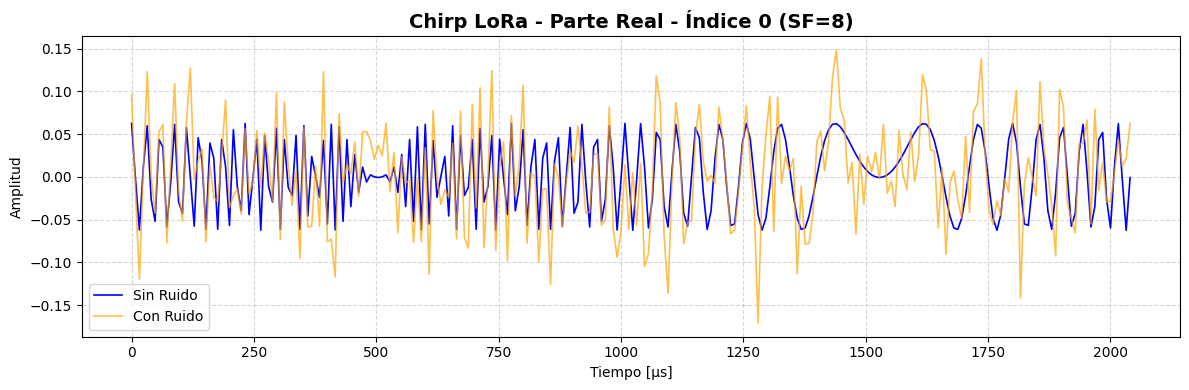

In [68]:
graficar_chirp_con_y_sin_ruido(simbolos_modulados, indice, SF, B, pot_ruido)


Ahora si, se simularan ambos canales AWGN y Selectivo en frecuencia, se realiza la grafica del BER vs SNR

In [69]:
# Configuración/Parametros
cant_simbolos = 50000
total_bits = SF * cant_simbolos


In [70]:
# Generación de bits aleatorios
bits_tx = generate_random_bits(total_bits)


------------------------------
BER VS CANAL AWGN
 Punto 1 - BER: 0.0280275
 Punto 2 - BER: 0.0083025
 Punto 3 - BER: 0.0016225
 Punto 4 - BER: 0.000145
------------------------------
BER VS CANAL SELECTIVO EN FRECUENCIA
Punto 1 - BER: 0.03054
Punto 2 - BER: 0.0114675
Punto 3 - BER: 0.0039425
Punto 4 - BER: 0.0016025
Punto 5 - BER: 0.000515
Punto 6 - BER: 0.0001375
Punto 7 - BER: 4e-05
------------------------------


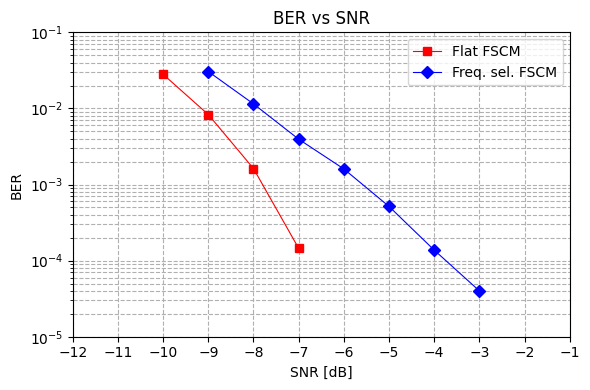

In [71]:
# Simulación del canal AWGN y multipath y graficar BER vs SNR
simulaciones_de_canal(bits_tx, SF, B, -10, -7, -9, -3)


En esta grafica vemos la relacion entre la tasa de bit errados vs la relacion señal ruido en db. Una relacion señal ruido igual a 0 nos dice que la potencia de la señal es igual a la potencia de ruido del canal. Una relacion señal ruido negativa nos indica que la potencia de ruido del canal es mayor que la potencia de la señal,lo que vemos que influye ne la tasa de bits errados al momento de la recepcion. 

En el paper de Vangelista se realiza la comparacion de la modulacion FSCM contra la modulacion FSK, y vimos que en el canal con ruido blanco gaussiano, no hay diferencia entre estas dos modulaciones al momento de aumentar la potencia de ruido y comparar su taza de error. Lo bueno de la modulacion FSCM contra la FSK viene al momento de compararlas en un canal selectivo en frecuencia, la modulacion de LoRa es mucho mas tolerante/resistente al ruido en comparacion de la modulacion FSK